In [1]:
!pip install python-Levenshtein

     -------------------------------------- 100.6/100.6 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 2.8 MB/s eta 0:00:00


In [28]:
import torch
import re
import pandas as pd
import pickle
import numpy as np
from gensim.models.phrases import Phraser
from torch.utils.data import TensorDataset, DataLoader

In [3]:
#process materials:
ev_path = "processors/Englishwords.xlsx"
sf_path =  "processors/Shortform.xlsx"
stopwords_vn_path = "processors/stopwords_vn_dash.txt"
englishwords = pd.read_excel(ev_path, index_col= "English")
shortform = pd.read_excel(sf_path, index_col= "Short")

#phraser for word2vec
bigram = Phraser.load("saves/bigram.pkl")

#word2idx
word2idx = pickle.load(open("saves/word2idx.pickle", "rb"))

In [4]:
print(englishwords)
# print(bigram)
# print(word2idx)

                Vietnamese
English                   
access            truy cập
adapter            cục sạc
ah                       à
ak                       à
app               ứng dụng
...                    ...
try           thử/ cố gắng
website          trang web
wireless         không dây
workshop  buổi diễn thuyết
wow                      ồ

[66 rows x 1 columns]


In [56]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [5]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [13]:
def isNaN(string):
    return string != string
def preprocess(text):  
  try:
    text = re.sub('<[^>]*>', '', text)
    text = deEmojify(text)
  except:
    print("An exception occurred", text)
  

  #thay chữ cái viết hoa thành viết thường
  text = text.lower()

  #xóa dấu ngắt câu, xóa link và các chữ có chứa chữ số
  clean_text = []
  punc_list = r'.,;:?!\|/&@`~()-_@#$%^*\'\"'
  for w in (text.split()):
    if "http" in w:
      continue
    clean_text.append(w)
  text = ' '.join(clean_text)
  for punc in punc_list:
    text = text.replace(punc, ' ')

  #xóa bỏ các chữ cái lặp liên tiếp nhau (đỉnhhhhhhhhhh, vipppppppppppppppp)
  length = len(text)
  char = 0
  while char <length-1:
    if text[char] == text[char+1]:
      text = text[:char]+text[char+1:]
      #print(text)
      length-=1
      continue
    char+=1  
  numbers = ["không", "một", "hai", "ba", "bốn", "năm", "sáu", "bảy", "tám", "chín"]
  #chuyển đổi các từ tiếng anh và viết tắt thông dụng sang tiếng Việt chuẩn:
  text_split = text.split()
  for i, w in enumerate(text_split):
    if w in englishwords.index:
      text_split[i] = str(englishwords.loc[w, "Vietnamese"])
    if w in shortform.index:
      text_split[i] = str(shortform.loc[w, "Long"])
    if w.isdigit():
      text_split[i] = ' '.join([numbers[int(c)] for c in w]) 
  text = ' '.join(text_split)

  #loại bỏ tất cả các kí tự đặc biệt còn lại
  digits_and_characters = 'aăâbcdđeêfghijklmnoôơpqrstuưvxywzáàảãạắằẳẵặấầẩẫậéèẻẽẹếềểễệíìỉĩịóòỏõọốồổỗộớờởỡợúùủũụứừửữựýỳỷỹỵ0123456789 '
  text = ''.join([i for i in text if i in digits_and_characters])
  return text


In [7]:
x = preprocess('aaa h ă âbcdđ h')
print(x)

a giờ ă âbcdđ giờ


In [8]:
#split all sentences in corpus
def splitCorpus(corpus):
  t = [sentence.split() for sentence in corpus]
  return t
#join all splited sentences to a big text document
def joinAllSplit(tokenized_sentences):
  sentences = [' '.join(sentence) for sentence in tokenized_sentences]
  return ' '.join(sentences)

#below function get performe preprocessing and remove unknown words
def prepros(sentences):
  new_sentences = [preprocess(sentence) for sentence in sentences]
  splitted_sentences = splitCorpus(new_sentences)
  new = []
  for sentence in bigram[splitted_sentences]:
    new_sentence = ' '.join([word for word in sentence if word in word2idx.keys()])
    new.append(new_sentence)
  return new

#convert words to numbers
def sentenceToInt(sentences):
  #print(sentences)
  int_sentences = []
  for sentence in sentences:
    int_sentence = [word2idx[word] for word in sentence.split()]   
    int_sentences.append(int_sentence)
  return int_sentences

#pad int_sentences to the feature_leng
def padFeature(sentences, feature_leng = 50):
  smatrix = np.zeros((len(sentences), feature_leng))
  for sen_index, sentence in enumerate(sentences):
    padding = max(0, feature_leng - len(sentence))
    for word_index in range(feature_leng):
      if word_index < padding:
        smatrix[sen_index, word_index] = 0
      else:
        smatrix[sen_index, word_index] = sentence[word_index-padding]
  return smatrix

def process(sentences, feature_leng = 50):
  int_sentences = sentenceToInt(sentences)
  feature_matrix = padFeature(int_sentences, feature_leng = 50)
  return feature_matrix


In [9]:
import torch.nn as nn

#model with 3 part: embedding layer -> stack lstms -> fc layers with softmax classifier
class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, output_size, embedding_dim, hidden_dim, n_layers, n_cell, emb_matrix, drop_prob = 0.2):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        #embedding layer
        self.embedding = nn.Embedding.from_pretrained(emb_matrix, freeze = False)
        # LSTM layers
        self.lstm = nn.LSTM(input_size = embedding_dim,hidden_size = hidden_dim, num_layers = n_layers, batch_first = True, dropout = drop_prob)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers 
        self.fc = nn.Linear(hidden_dim, output_size)
        #self.fc1 = nn.Linear(hidden_dim, hidden_dim*2)
        #self.relu1 = nn.LeakyReLU()
        #self.fc2 = nn.Linear(hidden_dim*2, output_size)
      
        self.softmax = nn.Softmax(dim = 1)
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        #print(x)
        # embeddings and lstm_out

        embeds = self.embedding(x)
        embeds = embeds.float()
        #print(type(embeds))
        #print(embeds)
        lstm_out, hidden = self.lstm(embeds, hidden)
        #print(lstm_out.shape)
        #stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        #print(lstm_out.shape)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        #print(out.shape)
        #out = lstm_out[:, -1, :]
        #print(out.shape)
        out = self.fc(out)
        #out = self.fc1(out)
        #out = self.fc2(out)
        #print(out.shape)
        # sigmoid function
        #print(out.shape)
        out = out.contiguous().view(batch_size, -1, self.output_size)
        out = out[:, -1, :]
        out = self.softmax(out)
        # reshape to be batch_size first
        #print(out.shape)
        #out = out.view(batch_size,n_cell, -1)
        #print(out.shape)
        #out = out[:, -1] # get last batch of labels
        #print(out.shape)
        # return last sigmoid output and hidden state

        return out, hidden
    
    
    def init_hidden(self, batch_size, train_on_gpu = False):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().float(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().float())
        
        return hidden

In [10]:
# Import Data
test = pd.read_csv("./input/test.csv")
train = pd.read_csv("./input/full_train.csv")

# drop columns 'RevId','UserId','image_urls', 'Unnamed: 0'
train.drop(columns=['RevId','UserId','image_urls', 'Unnamed: 0'], inplace=True)
test.drop(columns=['RevId','UserId','image_urls', 'Unnamed: 0'], inplace=True)
train.head()

,Comment,Rating
0,"Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trô...",1.0
1,Gọi ship 1 xuất cari gà bánh naan và 3 miếng g...,0.0
2,"Thời tiết lạnh như này, cả nhà rủ nhau đến leg...",1.0
3,Em có đọc review thấy mng bảo trà sữa nướng đề...,0.0
4,"Đồ ăn rất ngon, nhà hàng cũng rất đẹp, tất cả ...",1.0


In [11]:
from sklearn.model_selection import train_test_split
# split data into train and validation 
# train_df, valid_df = train_test_split(train)
# print(train_df.shape)
# print(valid_df.shape)

In [25]:
# Drop rows with empty text
print(train.shape)
train = train[train.Comment == train.Comment]
train = train[train.Rating == train.Rating]
print(train.shape)

X,y = train['Comment'].values,train['Rating'].values
# X = prepros(X)
# print(X)
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)

(9070, 2)
(9070, 2)


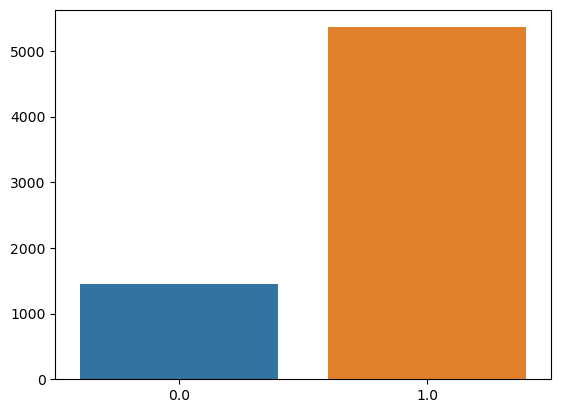

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array([1.0,0.0]),y=dd.values)
plt.show()

In [27]:
x_train = prepros(x_train)
x_train = process(x_train)
print(x_train)
print('====')
x_test = prepros(x_test)
x_test = process(x_test)
print(x_test)
print('====')
# print(y_train)
# print('====')
# print(y_test)

[[ 8093.  4946.  1071. ...  4600.  9516.  5907.]
 [    0.     0.     0. ...  1934. 10645.   477.]
 [ 2815.  9311.  2564. ...   542.  7067. 10463.]
 ...
 [    0.     0.     0. ... 10978. 11646.  6661.]
 [    0.     0.     0. ...  9419. 10707. 10721.]
 [    0.     0.     0. ...   943. 12219.  4262.]]
====
[[    0.     0.     0. ...  7343.  7596. 10389.]
 [ 3139.  5151. 10707. ... 10352.  9209.  4220.]
 [    0.     0.     0. ... 10721.  4551. 11146.]
 ...
 [   86.  9311.  4551. ...  8173.  1113.  6147.]
 [ 9068. 11730.  5236. ...  9419.   542.  4220.]
 [10707.  3139.  2097. ...  9516.  6958.  8360.]]
====


In [51]:
# create Tensor datasets


x_train = x_train.astype(np.int64)
y_train = y_train.astype(np.int64)
x_test = x_test.astype(np.int64)
y_test = y_test.astype(np.int64)
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
print(train_data)

from torch.autograd import Variable
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
# for i, (inputs, targets) in enumerate(train_loader):
#     with torch.no_grad():
#         inputs = Variable(inputs)
#         targets = Variable(targets)
#         print("targets.data", targets)
#         print("inputs.data", inputs)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [53]:
# obtain one batch of training data
print(train_loader)
dataiter = iter(train_loader)
print(dataiter)
# sample_x, sample_y = dataiter.next()
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 50])
Sample input: 
 tensor([[ 1677,  1071, 12304,  ...,   565,  3275,  8056],
        [ 6147, 11608,  2815,  ...,  9717,  4696,  3640],
        [    0,     0,     0,  ...,  5236,  5665,  3086],
        ...,
        [    0,     0,     0,  ..., 11730,  7225,  4391],
        [ 9491,  5151,  2564,  ..., 10319,  9516,  4448],
        [11455,  6321,  3032,  ...,  6127, 10821,  6574]])
Sample input: 
 tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        1, 1])


In [54]:
# #word2idx
# word2idx = pickle.load(open("saves/word2idx.pickle", "rb"))

# # Load model
# emb_matrix = torch.zeros((len(word2idx)+1,200))

# model = SentimentLSTM(output_size= 3, embedding_dim=200, hidden_dim= 128, n_layers= 2, n_cell = 50, emb_matrix=emb_matrix, drop_prob = 0.2)

# #moving to gpu
# # model.to(device)

# print(model)

SentimentLSTM(
  (embedding): Embedding(12345, 200)
  (lstm): LSTM(200, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [58]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [61]:
no_layers = 2
# vocab_size = len(vocab) + 1 #extra 1 for padding
# print(vocab_size)
vocab_size = len(word2idx)+1

embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(12345, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [62]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [63]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), './working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

RuntimeError: Expected hidden[0] size (2, 2, 256), got [2, 50, 256]